*This notebook contains race analysis of Rep-seq data for Cohort II. Specifically, correlations between gene usage and patient's race*

First, analysis was performed with only one batch of data, Hip. Some statistically signiicant result for several genes were found. However, when working with two batches, Keck and Hip, no stastically significant correlations were detected so far (not shown).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from scipy.stats import chi2_contingency, kruskal, fisher_exact
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from scikit_posthocs import posthoc_dunn

# Hip analysis

In [5]:
trbj = pd.read_csv('/home/svinogradova/american_beta/trbj_clean.csv').drop(['Unnamed: 0'], axis=1)
trbv = pd.read_csv('/home/svinogradova/american_beta/trbv_clean.csv').drop(['Unnamed: 0'], axis=1)

In [6]:
metadata = pd.read_csv('/projects/fmba_covid/hip_full/metadata.txt', sep='\t')
metadata

,file_name,sample_id,age,race,sex,cmv,hla,..filter..
0,../mixcr/../corr/HIP00110.txt,HIP00110,55.0,NaN,male,-,"HLA-A*03,HLA-A*24,HLA-B*07",corr:2:0.05:all
1,../mixcr/../corr/HIP00169.txt,HIP00169,41.0,NaN,male,-,"HLA-A*01,HLA-A*02,HLA-B*27,HLA-B*37",corr:2:0.05:all
2,../mixcr/../corr/HIP00594.txt,HIP00594,21.0,"caucasian,non-hispanic or latino",male,+,"HLA-A*02,HLA-A*32,HLA-B*07,HLA-B*61",corr:2:0.05:all
3,../mixcr/../corr/HIP00602.txt,HIP00602,45.0,NaN,female,-,"HLA-A*02,HLA-A*11,HLA-B*35,HLA-B*51",corr:2:0.05:all
4,../mixcr/../corr/HIP00614.txt,HIP00614,27.0,"caucasian,non-hispanic or latino",male,-,"HLA-A*03,HLA-A*29,HLA-B*07",corr:2:0.05:all
...,...,...,...,...,...,...,...,...
781,../mixcr/../corr/Keck0116_MC1.txt,Keck0116_MC1,19.0,"asian or pacific islander,non-hispanic or latino",female,-,NaN,corr:2:0.05:all
782,../mixcr/../corr/Keck0117_MC1.txt,Keck0117_MC1,34.0,"caucasian,non-hispanic or latino",male,+,NaN,corr:2:0.05:all
783,../mixcr/../corr/Keck0118_MC1.txt,Keck0118_MC1,28.0,"caucasian,non-hispanic or latino",male,+,NaN,corr:2:0.05:all
784,../mixcr/../corr/Keck0119_MC1.txt,Keck0119_MC1,24.0,"asian or pacific islander,non-hispanic or latino",female,+,NaN,corr:2:0.05:all


In [7]:
trbj = trbj.rename(columns={'id': 'sample_id'})
trbj['sample_id'] = trbj['sample_id'].apply(lambda x: x.split('.')[0])
trbv = trbv.rename(columns={'id': 'sample_id'})
trbv['sample_id'] = trbv['sample_id'].apply(lambda x: x.split('.')[0])

In [8]:
trbj_meta = pd.merge(trbj, metadata, on='sample_id')
trbv_meta = pd.merge(trbv, metadata, on='sample_id')

In [10]:
trbv_meta.race.value_counts()

race
caucasian,non-hispanic or latino                    377
hispanic or latino                                   26
asian or pacific islander,non-hispanic or latino     20
non-hispanic or latino                                9
black or african american,non-hispanic or latino      8
Name: count, dtype: int64

We selected genes with unnormal distribution, two or three Gaussians, for analysis. The hypothesis was as follows: presence of two or more picks could be a consequence of different races of patients.

# V genes

# TRBV7-4

We make subgroups based on usage and pick position. For example, here the two groups of patients we want to compare are those with gene usage less then 0.002 or more then 0.002.

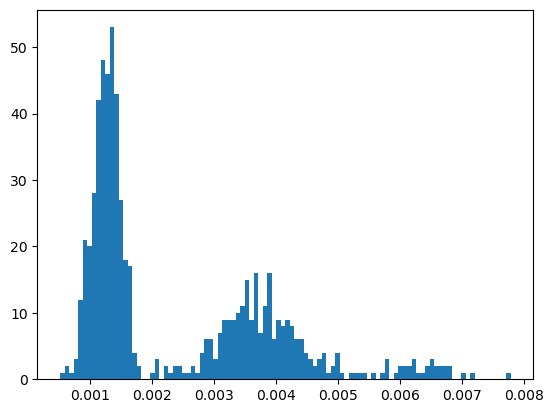

In [37]:
plt.hist(x=trbv['TRBV7-4'], bins=100);

In [38]:
trbv_meta['V7-4 group'] = trbv_meta.apply(lambda row: 0 if row['TRBV7-4'] < 0.002 else 1, axis=1)
trbv_meta['V7-4 group'].value_counts()

V7-4 group
0    389
1    276
Name: count, dtype: int64

In [39]:
contingency_table = pd.crosstab(trbv_meta['V7-4 group'], trbv_meta['race'])
contingency_table

race,"asian or pacific islander,non-hispanic or latino","black or african american,non-hispanic or latino","caucasian,non-hispanic or latino",hispanic or latino,non-hispanic or latino
V7-4 group,,,,,
0,19,4,211,21,9
1,1,4,166,5,0


In [40]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

8.888895675139802e-05

In [89]:
def test_race_associations(contingency_table, significance_level=0.05):
    """
    Perform chi-squared or Fisher's exact tests for all pairs of races in the contingency table
    and print significant results.

    Parameters:
    - contingency_table (pd.DataFrame): Contingency table with races as columns.
    - significance_level (float): Threshold for significance level (default is 0.05).
    """
    p_values = []
    races = contingency_table.columns.tolist()
    
    # Iterate over combinations of races
    for (race1, race2) in itertools.combinations(races, 2):
        sub_table = contingency_table[[race1, race2]]
        
        try:
        
            # Check if any expected frequency is less than 5 (typical threshold for chi-squared test)
            if sub_table.shape == (2, 2):
                oddsratio, p = fisher_exact(sub_table)
                test_used = "Fisher's exact test"
            else:
                chi2, p, dof, expected = chi2_contingency(sub_table)
                test_used = "Chi-squared test"

            p_values.append(p)

            # Print significant results
            if p < significance_level:
                print(f"{test_used} between {race1} and {race2} is significant (p-value = {p})")
            else:
                print(f"{test_used} between {race1} and {race2} is NOT significant (p-value = {p})")
        
        except ValueError as e:
            # Handle the case where chi2_contingency fails due to zero expected frequencies
            print(f"Skipping {race1} and {race2} due to insufficient data.")
            print(f"Error: {e}")

In [46]:
test_race_associations(contingency_table)

Fisher's exact test between asian or pacific islander,non-hispanic or latino and black or african american,non-hispanic or latino is significant (p-value = 0.014814814814814817)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and caucasian,non-hispanic or latino is significant (p-value = 0.0002814689207610629)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.21220587266605664)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and non-hispanic or latino is NOT significant (p-value = 1.0)
Fisher's exact test between black or african american,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.7358872210575992)
Fisher's exact test between black or african american,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.1647582280965779)
Fisher's exact test between black or african american,n

# TRBV7-3

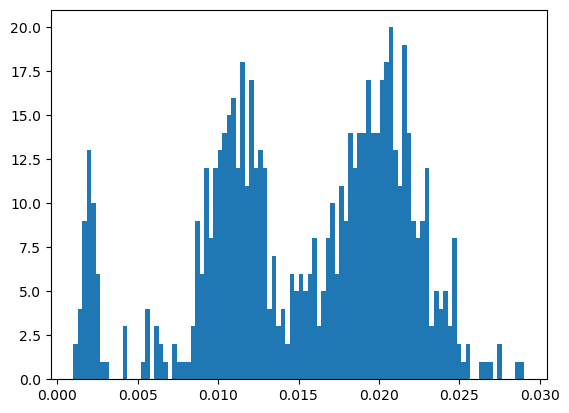

In [47]:
plt.hist(x=trbv['TRBV7-3'], bins=100);

In [48]:
trbv_meta['V7-3 group'] = trbv_meta.apply(lambda row: 0 if row['TRBV7-3'] < 0.005 else (1 if row['TRBV7-3'] < 0.015 else 2), axis=1)
trbv_meta['V7-3 group'].value_counts()

V7-3 group
2    366
1    250
0     49
Name: count, dtype: int64

In [49]:
contingency_table = pd.crosstab(trbv_meta['V7-3 group'], trbv_meta['race'])
contingency_table

race,"asian or pacific islander,non-hispanic or latino","black or african american,non-hispanic or latino","caucasian,non-hispanic or latino",hispanic or latino,non-hispanic or latino
V7-3 group,,,,,
0,1,1,28,1,0
1,3,3,151,5,1
2,16,4,198,20,8


In [50]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.047550977934508

In [51]:
test_race_associations(contingency_table)

Chi-squared test between asian or pacific islander,non-hispanic or latino and black or african american,non-hispanic or latino is NOT significant (p-value = 0.28365402649977034)
Chi-squared test between asian or pacific islander,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.05268334123111413)
Chi-squared test between asian or pacific islander,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.9209786944388716)
Chi-squared test between asian or pacific islander,non-hispanic or latino and non-hispanic or latino is NOT significant (p-value = 0.7492688553966849)
Chi-squared test between black or african american,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.8650709152754323)
Chi-squared test between black or african american,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.320645261338616)
Chi-squared test between black or african american,non-

In [52]:
trbv_meta['V7-3 group'] = trbv_meta.apply(lambda row: 0 if row['TRBV7-3'] < 0.005 else 1, axis=1)
trbv_meta['V7-3 group'].value_counts()

V7-3 group
1    616
0     49
Name: count, dtype: int64

In [53]:
contingency_table = pd.crosstab(trbv_meta['V7-3 group'], trbv_meta['race'])
contingency_table

race,"asian or pacific islander,non-hispanic or latino","black or african american,non-hispanic or latino","caucasian,non-hispanic or latino",hispanic or latino,non-hispanic or latino
V7-3 group,,,,,
0,1,1,28,1,0
1,19,7,349,25,9


In [54]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.797329967608933

In [55]:
trbv_meta['V7-3 group'] = trbv_meta.apply(lambda row: 0 if row['TRBV7-3'] < 0.015 else 1, axis=1)
trbv_meta['V7-3 group'].value_counts()

V7-3 group
1    366
0    299
Name: count, dtype: int64

In [56]:
contingency_table = pd.crosstab(trbv_meta['V7-3 group'], trbv_meta['race'])
contingency_table

race,"asian or pacific islander,non-hispanic or latino","black or african american,non-hispanic or latino","caucasian,non-hispanic or latino",hispanic or latino,non-hispanic or latino
V7-3 group,,,,,
0,4,4,179,6,1
1,16,4,198,20,8


In [57]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.004289809158271237

In [58]:
test_race_associations(contingency_table)

Fisher's exact test between asian or pacific islander,non-hispanic or latino and black or african american,non-hispanic or latino is NOT significant (p-value = 0.1719507545594502)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and caucasian,non-hispanic or latino is significant (p-value = 0.020046378853139597)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 1.0)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and non-hispanic or latino is NOT significant (p-value = 1.0)
Fisher's exact test between black or african american,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 1.0)
Fisher's exact test between black or african american,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.19485703068769222)
Fisher's exact test between black or african american,non-hispanic or latino and non

# TRBV6-3

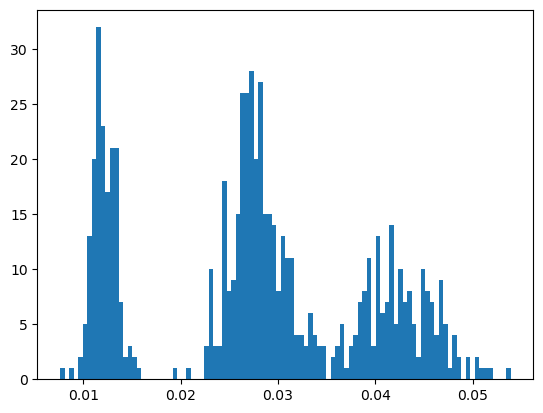

In [59]:
plt.hist(x=trbv['TRBV6-3'], bins=100);

In [60]:
trbv_meta['V6-3 group'] = trbv_meta.apply(lambda row: 0 if row['TRBV6-3'] < 0.02 else (1 if row['TRBV6-3'] < 0.035 else 2), axis=1)
trbv_meta['V6-3 group'].value_counts()

V6-3 group
1    311
2    182
0    172
Name: count, dtype: int64

In [61]:
contingency_table = pd.crosstab(trbv_meta['V6-3 group'], trbv_meta['race'])
contingency_table

race,"asian or pacific islander,non-hispanic or latino","black or african american,non-hispanic or latino","caucasian,non-hispanic or latino",hispanic or latino,non-hispanic or latino
V6-3 group,,,,,
0,7,3,97,10,7
1,10,3,174,11,1
2,3,2,106,5,1


In [62]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.04940604117087392

In [63]:
test_race_associations(contingency_table)

Chi-squared test between asian or pacific islander,non-hispanic or latino and black or african american,non-hispanic or latino is NOT significant (p-value = 0.7701624239734983)
Chi-squared test between asian or pacific islander,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.39183320547328643)
Chi-squared test between asian or pacific islander,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.8609154819448513)
Chi-squared test between asian or pacific islander,non-hispanic or latino and non-hispanic or latino is NOT significant (p-value = 0.08648447127088525)
Chi-squared test between black or african american,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.7510413023737932)
Chi-squared test between black or african american,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.9348581017065529)
Chi-squared test between black or african american,non

# TRBV4-3

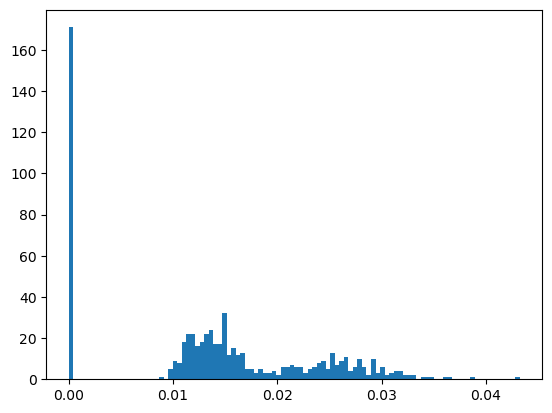

In [64]:
plt.hist(x=trbv['TRBV4-3'], bins=100);

In [65]:
trbv_meta['V4-3 group'] = trbv_meta.apply(lambda row: 0 if row['TRBV4-3'] < 0.01 else 1, axis=1)
trbv_meta['V4-3 group'].value_counts()

V4-3 group
1    488
0    177
Name: count, dtype: int64

In [66]:
contingency_table = pd.crosstab(trbv_meta['V4-3 group'], trbv_meta['race'])
contingency_table

race,"asian or pacific islander,non-hispanic or latino","black or african american,non-hispanic or latino","caucasian,non-hispanic or latino",hispanic or latino,non-hispanic or latino
V4-3 group,,,,,
0,7,3,100,10,7
1,13,5,277,16,2


In [67]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.009833453150953731

In [68]:
test_race_associations(contingency_table)

Fisher's exact test between asian or pacific islander,non-hispanic or latino and black or african american,non-hispanic or latino is NOT significant (p-value = 1.0)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.4397355739222093)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 1.0)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and non-hispanic or latino is NOT significant (p-value = 0.05017491254372814)
Fisher's exact test between black or african american,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.4457834676706549)
Fisher's exact test between black or african american,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 1.0)
Fisher's exact test between black or african american,non-hispanic or latino and n

# TRBV28

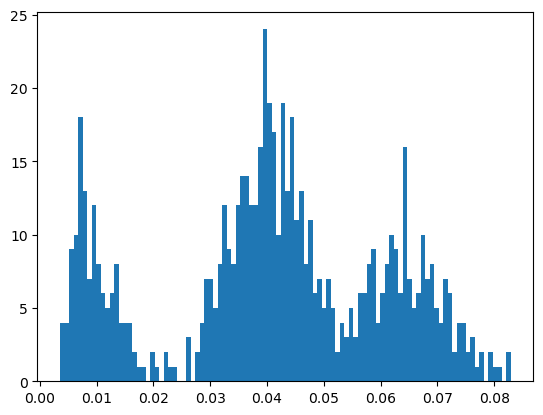

In [69]:
plt.hist(x=trbv['TRBV28'], bins=100);

In [70]:
trbv_meta['V28 group'] = trbv_meta.apply(lambda row: 0 if row['TRBV28'] < 0.02 else (1 if row['TRBV28'] < 0.055 else 2), axis=1)
trbv_meta['V28 group'].value_counts()

V28 group
1    358
2    180
0    127
Name: count, dtype: int64

In [71]:
contingency_table = pd.crosstab(trbv_meta['V28 group'], trbv_meta['race'])
contingency_table

race,"asian or pacific islander,non-hispanic or latino","black or african american,non-hispanic or latino","caucasian,non-hispanic or latino",hispanic or latino,non-hispanic or latino
V28 group,,,,,
0,3,7,67,3,1
1,9,1,205,19,6
2,8,0,105,4,2


In [72]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.00011123820523128129

In [73]:
test_race_associations(contingency_table)

Chi-squared test between asian or pacific islander,non-hispanic or latino and black or african american,non-hispanic or latino is significant (p-value = 0.00129402210546585)
Chi-squared test between asian or pacific islander,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.5022473388373463)
Chi-squared test between asian or pacific islander,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.1228551715736864)
Chi-squared test between asian or pacific islander,non-hispanic or latino and non-hispanic or latino is NOT significant (p-value = 0.548735417548757)
Chi-squared test between black or african american,non-hispanic or latino and caucasian,non-hispanic or latino is significant (p-value = 4.525465981082267e-06)
Chi-squared test between black or african american,non-hispanic or latino and hispanic or latino is significant (p-value = 0.00019854014613213862)
Chi-squared test between black or african american,non-hispan

# TRBV11-3

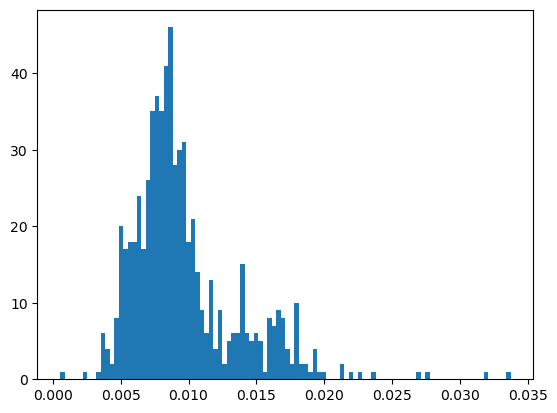

In [74]:
plt.hist(x=trbv['TRBV11-3'], bins=100);

In [75]:
trbv_meta['V11-3 group'] = trbv_meta.apply(lambda row: 0 if row['TRBV11-3'] < 0.0125 else 1, axis=1)
trbv_meta['V11-3 group'].value_counts()

V11-3 group
0    540
1    125
Name: count, dtype: int64

In [76]:
contingency_table = pd.crosstab(trbv_meta['V11-3 group'], trbv_meta['race'])
contingency_table

race,"asian or pacific islander,non-hispanic or latino","black or african american,non-hispanic or latino","caucasian,non-hispanic or latino",hispanic or latino,non-hispanic or latino
V11-3 group,,,,,
0,16,7,314,18,5
1,4,1,63,8,4


In [77]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.10286068661008456

In [78]:
test_race_associations(contingency_table)

Fisher's exact test between asian or pacific islander,non-hispanic or latino and black or african american,non-hispanic or latino is NOT significant (p-value = 1.0)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.7580866448983905)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.508559690068482)
Fisher's exact test between asian or pacific islander,non-hispanic or latino and non-hispanic or latino is NOT significant (p-value = 0.20893259663874356)
Fisher's exact test between black or african american,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 1.0)
Fisher's exact test between black or african american,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.40304041527623286)
Fisher's exact test between black or african american,non-hispanic 

# TRBV10-2

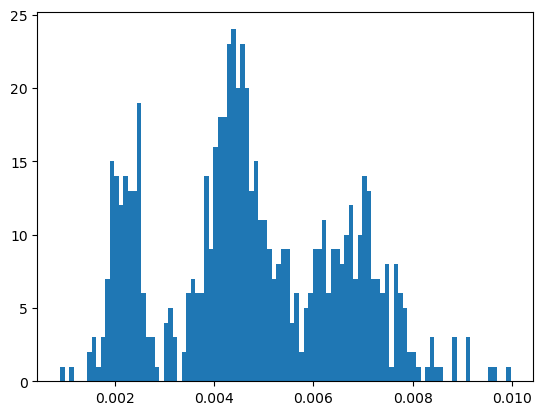

In [90]:
plt.hist(x=trbv['TRBV10-2'], bins=100);

In [91]:
trbv_meta['V10-2 group'] = trbv_meta.apply(lambda row: 0 if row['TRBV10-2'] < 0.003 else (1 if row['TRBV28'] < 0.006 else 2), axis=1)
trbv_meta['V10-2 group'].value_counts()

V10-2 group
2    521
0    131
1     13
Name: count, dtype: int64

In [92]:
contingency_table = pd.crosstab(trbv_meta['V10-2 group'], trbv_meta['race'])
contingency_table

race,"asian or pacific islander,non-hispanic or latino","black or african american,non-hispanic or latino","caucasian,non-hispanic or latino",hispanic or latino,non-hispanic or latino
V10-2 group,,,,,
0,3,0,72,5,1
1,0,1,7,1,0
2,17,7,298,20,8


In [93]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.4751830645089682

In [94]:
test_race_associations(contingency_table)

Chi-squared test between asian or pacific islander,non-hispanic or latino and black or african american,non-hispanic or latino is NOT significant (p-value = 0.15690992987345742)
Chi-squared test between asian or pacific islander,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.7315873364132006)
Chi-squared test between asian or pacific islander,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.6134659869389066)
Skipping asian or pacific islander,non-hispanic or latino and non-hispanic or latino due to insufficient data.
Error: The internally computed table of expected frequencies has a zero element at (1, 0).
Chi-squared test between black or african american,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.05315361024672804)
Chi-squared test between black or african american,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.3006690820347128)
Chi

# Kruskal–Wallis test

Now we compare distributions of each gene with unimodal (by eye) distribution across different racial groups.

In [95]:
genes_to_test = ['TRBV9', 'TRBV7-9', 'TRBV7-8', 'TRBV7-7', 'TRBV7-6', 'TRBV7-5','TRBV7-2', 'TRBV7-1', 'TRBV6-9', 'TRBV6-8',
       'TRBV6-7', 'TRBV6-6', 'TRBV6-5', 'TRBV6-4', 'TRBV6-1',
       'TRBV5-8', 'TRBV5-7', 'TRBV5-6', 'TRBV5-5', 'TRBV5-4', 'TRBV5-3',
       'TRBV5-2', 'TRBV5-1', 'TRBV4-2', 'TRBV4-1', 'TRBV30',
       'TRBV3-2', 'TRBV3-1', 'TRBV29-1', 'TRBV27', 'TRBV26',
       'TRBV25-1', 'TRBV24-1', 'TRBV23-1', 'TRBV22-1', 'TRBV21-1', 'TRBV20-1',
       'TRBV2', 'TRBV19', 'TRBV18', 'TRBV17', 'TRBV16', 'TRBV15', 'TRBV14',
       'TRBV13', 'TRBV12-5', 'TRBV12-4', 'TRBV12-2', 'TRBV12-1',
       'TRBV11-2', 'TRBV11-1', 'TRBV10-3', 'TRBV10-1', 'TRBV1']

In [96]:
results = {}

for gene in genes_to_test:
    groups = trbv_meta.groupby('race')[gene].apply(list)
    stat, p_value = kruskal(*groups)
    results[gene] = p_value
    
num_tests = len(results)
alpha = 0.05
bonferroni_threshold = alpha / num_tests

corrected_results = {}
for gene, p_value in results.items():
    adjusted_p = p_value * num_tests
    if adjusted_p > 1:
        adjusted_p = 1
    corrected_results[gene] = adjusted_p

In [97]:
significant_genes_bonferroni = {gene: p for gene, p in corrected_results.items() if p < alpha}
significant_genes_bonferroni

{'TRBV7-6': 0.005827468044483552,
 'TRBV4-1': 0.0014716915891307219,
 'TRBV16': 0.0017172673132878243,
 'TRBV14': 0.010037304346067973,
 'TRBV13': 0.005813887795723745,
 'TRBV12-5': 0.008892597092857118}

Let's plot these genes to see their distribution:

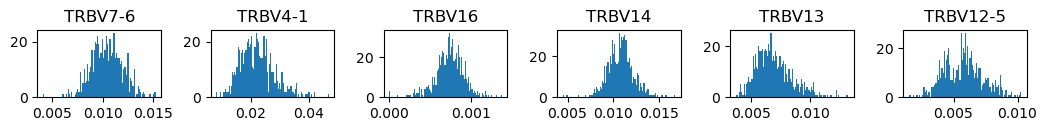

In [98]:
plt.figure(figsize=(15,15))

for i, column in enumerate(trbv_meta[significant_genes_bonferroni.keys()].columns):
    plt.subplot(10, 7, i+1)
    plt.hist(x=trbv_meta[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()

# J genes

# TRBJ1-6

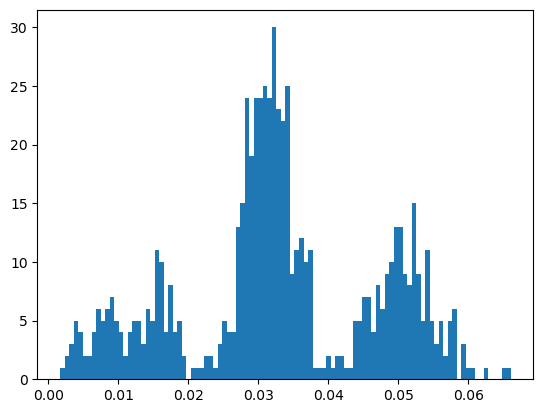

In [105]:
plt.hist(x=trbj['TRBJ1-6'], bins=100);

In [106]:
trbj_meta['J1-6 group'] = trbj_meta.apply(lambda row: 0 if row['TRBJ1-6'] < 0.02 else (1 if row['TRBJ1-6'] < 0.04 else 2), axis=1)
trbj_meta['J1-6 group'].value_counts()

J1-6 group
1    348
2    187
0    130
Name: count, dtype: int64

In [107]:
contingency_table = pd.crosstab(trbj_meta['J1-6 group'], trbj_meta['race'])
contingency_table

race,"asian or pacific islander,non-hispanic or latino","black or african american,non-hispanic or latino","caucasian,non-hispanic or latino",hispanic or latino,non-hispanic or latino
J1-6 group,,,,,
0,12,1,69,4,3
1,6,3,196,13,3
2,2,4,112,9,3


In [108]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.0020746457247974334

In [109]:
test_race_associations(contingency_table)

Chi-squared test between asian or pacific islander,non-hispanic or latino and black or african american,non-hispanic or latino is significant (p-value = 0.02810536285849973)
Chi-squared test between asian or pacific islander,non-hispanic or latino and caucasian,non-hispanic or latino is significant (p-value = 3.43347189498756e-05)
Chi-squared test between asian or pacific islander,non-hispanic or latino and hispanic or latino is significant (p-value = 0.005439045800409859)
Chi-squared test between asian or pacific islander,non-hispanic or latino and non-hispanic or latino is NOT significant (p-value = 0.2422517564238788)
Chi-squared test between black or african american,non-hispanic or latino and caucasian,non-hispanic or latino is NOT significant (p-value = 0.4644483257976002)
Chi-squared test between black or african american,non-hispanic or latino and hispanic or latino is NOT significant (p-value = 0.734754165272365)
Chi-squared test between black or african american,non-hispanic 

In [110]:
genes_to_test = ['TRBJ2-7',
 'TRBJ2-6',
 'TRBJ2-5',
 'TRBJ2-4',
 'TRBJ2-3',
 'TRBJ2-2',
 'TRBJ2-1',
 'TRBJ1-5',
 'TRBJ1-4',
 'TRBJ1-3',
 'TRBJ1-2',
 'TRBJ1-1',]

In [111]:
results = {}

for gene in genes_to_test:
    groups = trbj_meta.groupby('race')[gene].apply(list)
    stat, p_value = kruskal(*groups)
    results[gene] = p_value
    
num_tests = len(results)
alpha = 0.05
bonferroni_threshold = alpha / num_tests

corrected_results = {}
for gene, p_value in results.items():
    adjusted_p = p_value * num_tests
    if adjusted_p > 1:
        adjusted_p = 1
    corrected_results[gene] = adjusted_p

In [112]:
significant_genes_bonferroni = {gene: p for gene, p in corrected_results.items() if p < alpha}
significant_genes_bonferroni

{}

In [113]:
results

{'TRBJ2-7': 0.46006528454989293,
 'TRBJ2-6': 0.45074393596873996,
 'TRBJ2-5': 0.36857127874754747,
 'TRBJ2-4': 0.20150258584839373,
 'TRBJ2-3': 0.09602499194203462,
 'TRBJ2-2': 0.27383736924048424,
 'TRBJ2-1': 0.05328849517267717,
 'TRBJ1-5': 0.03724813744120652,
 'TRBJ1-4': 0.054831136886479726,
 'TRBJ1-3': 0.18410136326630505,
 'TRBJ1-2': 0.11528390767496755,
 'TRBJ1-1': 0.7851117393268856}